In [13]:
import random
import math
import matplotlib.pyplot as plt

# Lista completa com 30 cidades
cidades = [
    (5, 10), (15, 25), (30, 5), (40, 20), (20, 40),
    (35, 35), (10, 30), (50, 45), (45, 10), (60, 30),
    (25, 15), (55, 20), (70, 10), (80, 25), (65, 40),
    (90, 30), (75, 50), (85, 15), (95, 35), (40, 50),
    (10, 5), (20, 25), (35, 10), (50, 15), (60, 5),
    (70, 20), (30, 50), (45, 25), (55, 35), (65, 15)
]

ponto_inicial = (30, 30)
n_total_cidades = len(cidades)
cidades_visitadas = 15
n_caixeiros = 3


In [14]:
def distancia(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)


def torneio(populacao, k=3):
    competidores = random.sample(populacao, k)
    return max(competidores, key=lambda ind: ind.fitness())


class Individuo:
    def __init__(self, rotas=None, cidades=None, ponto_inicial=None, selecionadas=None):
        self.cidades = cidades
        self.ponto_inicial = ponto_inicial

        if rotas is None:
            self.rotas = [[] for _ in range(n_caixeiros)]
            if selecionadas is not None:
                aleatorias = selecionadas[:]
                random.shuffle(aleatorias)
                for cidade in aleatorias:
                    destino = random.randint(0, n_caixeiros - 1)
                    self.rotas[destino].append(cidade)
            else:
                raise ValueError("Precisa fornecer 'selecionadas' se 'rotas' for None.")
        else:
            self.rotas = [r[:] for r in rotas]

        self._fitness = None


    def fitness(self):
        if self._fitness is not None:
            return self._fitness

        distancias = []
        for rota in self.rotas:
            rota_coords = [self.ponto_inicial] + [self.cidades[i] for i in rota] + [self.ponto_inicial]
            total = sum(distancia(rota_coords[i], rota_coords[i + 1]) for i in range(len(rota_coords) - 1))
            distancias.append(total)

        distancia_total = sum(distancias)
        media = distancia_total / n_caixeiros
        desvio = math.sqrt(sum((d - media) ** 2 for d in distancias) / n_caixeiros)

        # Penalidade proporcional ao desvio: mais desigual, pior
        penalidade = desvio * 2

        custo = distancia_total + penalidade
        self._fitness = 1 / (1 + custo)
        return self._fitness


    def mutacao(self):
        nova_rotas = [r[:] for r in self.rotas]
        origem, destino = random.sample(range(n_caixeiros), 2)

        qtd_mover = random.randint(1, max(1, len(nova_rotas[origem]) // 2))
        for _ in range(qtd_mover):
            if not nova_rotas[origem]:
                break
            cidade_idx = random.randrange(len(nova_rotas[origem]))
            cidade = nova_rotas[origem].pop(cidade_idx)
            insert_pos = random.randint(0, len(nova_rotas[destino]))
            nova_rotas[destino].insert(insert_pos, cidade)

        return Individuo(nova_rotas, cidades=self.cidades, ponto_inicial=self.ponto_inicial, selecionadas=None)

    def crossover(self, outro):
        filho_rotas = [[] for _ in range(n_caixeiros)]
        usados = set()

        for i in range(n_caixeiros):
            for cidade in self.rotas[i]:
                if cidade not in usados and len(usados) < cidades_visitadas:
                    filho_rotas[i].append(cidade)
                    usados.add(cidade)

        for i in range(n_caixeiros):
            for cidade in outro.rotas[i]:
                if cidade not in usados and len(usados) < cidades_visitadas:
                    filho_rotas[i].append(cidade)
                    usados.add(cidade)

        restantes = [i for i in range(n_total_cidades) if i not in usados]
        random.shuffle(restantes)
        for cidade in restantes:
            if len(usados) >= cidades_visitadas:
                break
            menor = min(filho_rotas, key=lambda r: len(r))
            menor.append(cidade)
            usados.add(cidade)

        return Individuo(filho_rotas, cidades=self.cidades, ponto_inicial=self.ponto_inicial, selecionadas=None)

    def imprime(self):
        saida = ""
        distancias = []
        
        for i, rota in enumerate(self.rotas):
            coords_rota = [self.ponto_inicial] + [self.cidades[idx] for idx in rota] + [self.ponto_inicial]
            distancia_rota = sum(distancia(coords_rota[i], coords_rota[i + 1]) for i in range(len(coords_rota) - 1))
            distancias.append(distancia_rota)
            saida += f"Caixeiro {i + 1}: {coords_rota}\n |  Distância: {distancia_rota:.2f}\n"
        saida += f"Fitness: {self.fitness():.5f} |"
        return saida

In [15]:
class Populacao:
    def __init__(self, tamanho_populacao, cidades, ponto_inicial, cidades_escolhidas):
        self.tamanho_populacao = tamanho_populacao
        self.cidades = cidades
        self.ponto_inicial = ponto_inicial
        self.indices_escolhidos = cidades_escolhidas
        self.populacao = []

    def inicializacao(self):
        self.populacao = [
            Individuo(cidades=self.cidades, ponto_inicial=self.ponto_inicial, selecionadas=self.indices_escolhidos)
            for _ in range(self.tamanho_populacao)
        ]

    def mutacao(self):
        return [ind.mutacao() for ind in self.populacao]

    def crossover(self):
        nova_lista = []
        for _ in range(self.tamanho_populacao):
            pai1 = torneio(self.populacao)
            pai2 = torneio(self.populacao)
            filho = pai1.crossover(pai2)
            nova_lista.append(filho)
        return nova_lista

    def selecao(self, populacao_mutada=[], populacao_crossover=[]):
        combinado = self.populacao + populacao_mutada + populacao_crossover
        combinado.sort(key=lambda ind: ind.fitness(), reverse=True)
        self.populacao = combinado[:self.tamanho_populacao]

    def top_fitness(self):
        return self.top_individuo().fitness()

    def top_individuo(self):
        return self.populacao[0]


In [16]:
class AlgoritmoGeneticoPopulacao:
    def __init__(self, populacao):
        self.populacao = populacao
        self.erro = float('inf')
        self.geracoes = 1

    def rodar(self, max_geracoes=1000, imprimir_em_geracoes=100, erro_min=0.01):
        print(f"Geração: {self.geracoes}, Erro: {round(self.erro, 3)}\n{self.populacao.top_individuo().imprime()}")
        while True:
            if self.geracoes >= max_geracoes or self.erro <= erro_min:
                print(f"Geração: {self.geracoes}, Erro: {self.erro}\n{self.populacao.top_individuo().imprime()}")
                break

            mutantes = self.populacao.mutacao()
            filhos = self.populacao.crossover()
            self.populacao.selecao(mutantes, filhos)

            fitness = self.populacao.top_fitness()
            if (1 - fitness) < self.erro:
                self.erro = 1 - fitness

            if self.geracoes % 100 == 0:
                n_substituir = self.populacao.tamanho_populacao // 10
                for _ in range(n_substituir):
                    pos = random.randint(0, self.populacao.tamanho_populacao - 1)
                    self.populacao.populacao[pos] = Individuo(
                        cidades=self.populacao.cidades,
                        ponto_inicial=self.populacao.ponto_inicial,
                        selecionadas=self.populacao.indices_escolhidos
                    )

            self.geracoes += 1

            if self.geracoes % imprimir_em_geracoes == 0:
                print(f"Geração: {self.geracoes}, Erro: {self.erro}\n{self.populacao.top_individuo().imprime()}")

        return self.populacao.top_individuo()

In [17]:
def plotar_rotas(individuo):
    cores = ['blue', 'green', 'red']
    plt.figure(figsize=(10, 8))

    for i, rota in enumerate(individuo.rotas):
        coords = [individuo.ponto_inicial] + [individuo.cidades[idx] for idx in rota] + [individuo.ponto_inicial]
        x, y = zip(*coords)
        plt.plot(x, y, marker='o', color=cores[i], label=f"Caixeiro {i + 1}")
        for ponto in coords:
            plt.scatter(*ponto, color=cores[i])

    plt.scatter(*individuo.ponto_inicial, color='black', s=100, label="Ponto Inicial")
    plt.title("Rotas dos Caixeiros-Viajantes")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.show()

Cidades escolhidas para o problema:
14: (65, 40)
1: (15, 25)
28: (55, 35)
23: (50, 15)
8: (45, 10)
24: (60, 5)
2: (30, 5)
29: (65, 15)
15: (90, 30)
10: (25, 15)
4: (20, 40)
12: (70, 10)
16: (75, 50)
20: (10, 5)
6: (10, 30)
Geração: 1, Erro: inf
Caixeiro 1: [(30, 30), (30, 5), (25, 15), (30, 30)]
 |  Distância: 51.99
Caixeiro 2: [(30, 30), (65, 40), (55, 35), (75, 50), (70, 10), (30, 30)]
 |  Distância: 157.61
Caixeiro 3: [(30, 30), (10, 5), (15, 25), (50, 15), (60, 5), (90, 30), (10, 30), (20, 40), (45, 10), (65, 15), (30, 30)]
 |  Distância: 334.11
Fitness: 0.00129 |
Geração: 50, Erro: 0.9973668505341178
Caixeiro 1: [(30, 30), (25, 15), (30, 5), (10, 5), (15, 25), (10, 30), (20, 40), (30, 30)]
 |  Distância: 102.96
Caixeiro 2: [(30, 30), (55, 35), (65, 40), (75, 50), (90, 30), (30, 30)]
 |  Distância: 135.82
Caixeiro 3: [(30, 30), (45, 10), (70, 10), (60, 5), (65, 15), (50, 15), (30, 30)]
 |  Distância: 112.36
Fitness: 0.00263 |
Geração: 100, Erro: 0.9973668505341178
Caixeiro 1: [(30,

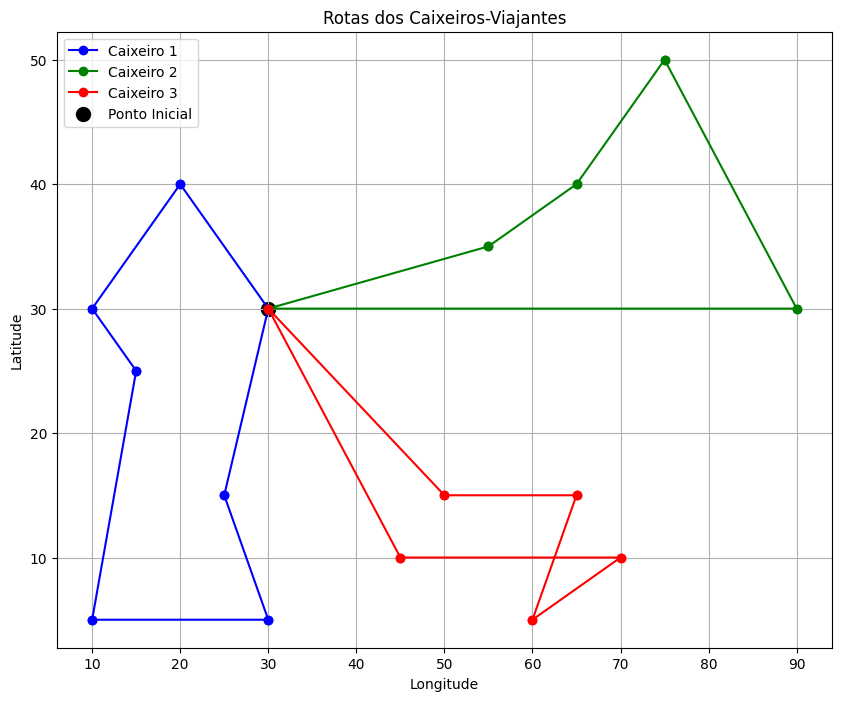

In [18]:
if __name__ == "__main__":
    indices_escolhidos = random.sample(range(len(cidades)), cidades_visitadas)

    print("Cidades escolhidas para o problema:")
    for idx in indices_escolhidos:
        print(f"{idx}: {cidades[idx]}")

    pop = Populacao(
        tamanho_populacao=50,
        cidades=cidades,
        ponto_inicial=ponto_inicial,
        cidades_escolhidas=indices_escolhidos
    )
    pop.inicializacao()

    ag = AlgoritmoGeneticoPopulacao(pop)
    melhor = ag.rodar(max_geracoes=1000, imprimir_em_geracoes=50, erro_min=0.001)

    print("\nMelhor solução encontrada:")
    print(melhor.imprime())
    plotar_rotas(melhor)
